In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.externals import joblib

In [3]:
train = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/train.csv', na_values=-1)
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)

unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

In [4]:
unwanted = list(unwanted)
unwanted.remove('ps_calc_01')
unwanted.append('ps_ind_12_bin')

===========================================

In [3]:
model = joblib.load('C:/Users/KrystalU/PycharmProjects/Toy/xgb1.pkl')

In [16]:
model.get_xgb_params

<bound method XGBClassifier.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.8, learning_rate=0.01,
       max_delta_step=1.5, max_depth=7, min_child_weight=9, missing=nan,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)>

In [11]:
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)
unwanted = test.columns[test.columns.str.startswith('ps_calc_')]
test = test.drop(unwanted, axis=1)
sub = pd.DataFrame()
sub['id'] = test['id']
sub['target'] = np.zeros_like(test['id'])
test = test.drop('id', axis=1)
d_test = xgb.DMatrix(test.values)
pred_prob = model.predict_proba(test.values)

In [14]:
sub['target'] = pred_prob[:,1]
sub.to_csv('sub12.csv',index=False)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from time import time

print('loading files...')
train = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/train.csv', na_values=-1)
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)

unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

# custom objective function (similar to auc)
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

# xgb
print 'xgb start...'

X = train.drop(['id', 'target'], axis=1)
features = X.columns
X = X.values
y = train['target'].values
sub = test['id'].to_frame()
sub['target'] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
-

loading files...
xgb start...


C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 11.8min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 72.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 233.6min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 439.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 695.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 990.9min


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from time import time

print('loading files...')
train = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/train.csv', na_values=-1)
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)

for c in train.select_dtypes(include=['float64']).columns:
    train[c]=train[c].astype(np.float32)
    test[c]=test[c].astype(np.float32)
for c in train.select_dtypes(include=['int64']).columns[2:]:
    train[c]=train[c].astype(np.int8)
    test[c]=test[c].astype(np.int8)

print(train.shape, test.shape)

unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

new_fea_csv = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/new_fea_name.csv')
new_fea_name = list(set(new_fea_csv['feature']) - set(['ps_car_13']))

candidates = ['ps_car_13','ps_reg_03','ps_car_14','ps_ind_03',
             'ps_car_11_cat','ps_ind_15','ps_reg_01','ps_ind_01',
             'ps_reg_02','ps_car_01_cat','ps_calc_14','ps_calc_03',
             'ps_car_06_cat','ps_calc_10','ps_car_15','ps_calc_11',
             'ps_car_12','ps_calc_02','ps_calc_01','ps_calc_08']

total = 0
for i in xrange(len(candidates)):
    for j in xrange(i+1,len(candidates)):
        col1, col2 = candidates[i], candidates[j]
        for op in ['*', '+', '-']:
            new_col = '{}{}{}'.format(col1, op, col2)
            if new_col in new_fea_name:
                if op == '*':
                    train[new_col] = train[col1] * train[col2]
                    test[new_col] = test[col1] * test[col2]
                elif op == '-':
                    train[new_col] = train[col1] - train[col2]
                    test[new_col] = test[col1] - test[col2]
                else:
                    train[new_col] = train[col1] + train[col2]
                    test[new_col] = test[col1] + test[col2]
                total += 1
print '# of new features: {}'.format(total)

train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

# custom objective function (similar to auc)
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True


# xgb
print 'xgb start...'

X = train.drop(['id', 'target'], axis=1)
features = X.columns
X = X.values
y = train['target'].values
sub = test['id'].to_frame()
sub['target'] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
param_dist = {
    'min_child_weight': [5,7,9],
    'max_depth': [10],
    'max_delta_step': [1.5, 1.8, 2.0],
    'colsample_bytree': [0.4, 0.6],
    'subsample': [0.8, 0.9],
    'learning_rate': [0.01, 0.025, 0.05],
    'gamma': [0.5, 0.65, 0.8],
    'n_estimators' : [500, 1000, 1500, 2000]
    }

fit_dict = {"eval_set":[(X_test, y_test)],
            "early_stopping_rounds": 100,
            'eval_metric' : 'auc'}

xgb_tune = xgb.XGBClassifier(random_state=42, objective='binary:logistic')
n_iter_search = 250
# gini_scorer = make_scorer(gini_normalized, greater_is_better=True)
random_search = RandomizedSearchCV(estimator = xgb_tune,
                                   param_distributions = param_dist,
                                   scoring = 'roc_auc',
                                   n_iter=n_iter_search,
                                   random_state=42,
                                   cv=5,
                                   verbose=5,
                                   n_jobs=8,
                                   fit_params=fit_dict)
start = time()
random_search.fit(X_train, y_train)
print 'Training time: {} mins.'.format((time() - start) / 60)

loading files...
((595212, 59), (892816, 58))
# of new features: 23
xgb start...


C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 19.7min


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from time import time

print('loading files...')
train = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/train.csv', na_values=-1)
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)

for c in train.select_dtypes(include=['float64']).columns:
    train[c]=train[c].astype(np.float32)
    test[c]=test[c].astype(np.float32)
for c in train.select_dtypes(include=['int64']).columns[2:]:
    train[c]=train[c].astype(np.int8)
    test[c]=test[c].astype(np.int8)

print(train.shape, test.shape)

unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

new_fea_csv = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/new_fea_name.csv')
new_fea_name = list(set(new_fea_csv['feature']) - set(['ps_car_13']))

candidates = ['ps_car_13','ps_reg_03','ps_car_14','ps_ind_03',
             'ps_car_11_cat','ps_ind_15','ps_reg_01','ps_ind_01',
             'ps_reg_02','ps_car_01_cat','ps_calc_14','ps_calc_03',
             'ps_car_06_cat','ps_calc_10','ps_car_15','ps_calc_11',
             'ps_car_12','ps_calc_02','ps_calc_01','ps_calc_08']

cand_calc_col = [item for item in candidates if 'calc' in item]
unwanted = list(set(unwanted)-set(cand_calc_col))

total = 0
for i in xrange(len(candidates)):
    for j in xrange(i+1,len(candidates)):
        col1, col2 = candidates[i], candidates[j]
        for op in ['*', '+', '-']:
            new_col = '{}{}{}'.format(col1, op, col2)
            if new_col in new_fea_name:
                if op == '*':
                    train[new_col] = train[col1] * train[col2]
                    test[new_col] = test[col1] * test[col2]
                elif op == '-':
                    train[new_col] = train[col1] - train[col2]
                    test[new_col] = test[col1] - test[col2]
                else:
                    train[new_col] = train[col1] + train[col2]
                    test[new_col] = test[col1] + test[col2]
                total += 1
print '# of new features: {}'.format(total)

train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

-

loading files...
((595212, 59), (892816, 58))
# of new features: 23
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.227193	valid-gini:0.215442
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.339886	valid-gini:0.265355
[200]	train-error:0.036428	valid-error:0.036457	train-gini:0.391282	valid-gini:0.274704
[300]	train-error:0.036416	valid-error:0.036466	train-gini:0.435268	valid-gini:0.277835
[400]	train-error:0.036414	valid-error:0.036466	train-gini:0.467759	valid-gini:0.278271
Stopping. Best iteration:
[371]	train-error:0.036414	valid-error:0.036466	train-gini:0.460156	valid-gini:0.278668

Training time: 5.78928333521 mins.


loading files...
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.05479	valid-gini:0.03578
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.326695	valid-gini:0.265545
[200]	train-error:0.036443	valid-error:0.036449	train-gini:0.377005	valid-gini:0.27505
[300]	train-error:0.036426	valid-error:0.036466	train-gini:0.423122	valid-gini:0.279963
[400]	train-error:0.03642	valid-error:0.036466	train-gini:0.459814	valid-gini:0.280923
Stopping. Best iteration:
[391]	train-error:0.03642	valid-error:0.036466	train-gini:0.456776	valid-gini:0.281033

In [4]:
import operator
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

features = X.columns
create_feature_map(features)
importance = xgb_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
print df
print '=================='
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('C:/Users/KrystalU/Documents/Data/Driver/feature_importance_xgb.png')

                    feature    fscore
0   ps_car_13+ps_car_01_cat  0.042737
1       ps_reg_03-ps_ind_15  0.036567
2       ps_reg_03-ps_reg_02  0.035417
3       ps_car_13-ps_car_14  0.033081
4       ps_car_13+ps_reg_01  0.031861
5      ps_car_14+ps_calc_02  0.031269
6       ps_reg_03+ps_ind_15  0.031025
7       ps_car_14-ps_car_12  0.030850
8       ps_reg_03*ps_ind_03  0.030223
9       ps_car_13+ps_reg_02  0.030153
10      ps_reg_03-ps_ind_03  0.029386
11      ps_car_14-ps_ind_03  0.028759
12      ps_reg_03+ps_ind_03  0.028619
13      ps_car_13+ps_ind_03  0.028410
14                ps_reg_03  0.028236
15      ps_reg_03*ps_ind_15  0.027329
16      ps_car_14-ps_reg_02  0.027085
17      ps_car_14+ps_ind_03  0.025796
18                ps_car_13  0.025691
19      ps_car_13*ps_car_14  0.025587
20      ps_car_13+ps_car_12  0.025377
21      ps_reg_03*ps_reg_02  0.023913
22      ps_car_14*ps_ind_03  0.023495
23                ps_car_14  0.022902
24      ps_car_14*ps_car_12  0.020497
25      ps_c

NameError: name 'plt' is not defined

In [9]:
candidates

['ps_car_13',
 'ps_reg_03',
 'ps_car_14',
 'ps_ind_03',
 'ps_car_11_cat',
 'ps_ind_15',
 'ps_reg_01',
 'ps_ind_01',
 'ps_reg_02',
 'ps_car_01_cat',
 'ps_calc_14',
 'ps_calc_03',
 'ps_car_06_cat',
 'ps_calc_10',
 'ps_car_15',
 'ps_calc_11',
 'ps_car_12',
 'ps_calc_02',
 'ps_calc_01',
 'ps_calc_08']

In [6]:
from __future__ import division
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import operator
from matplotlib import pylab as plt

print('loading files...')
train = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver/train.csv', na_values=-1)
test = pd.read_csv('C:/Users/KrystalU/Documents/Data/Driver//test.csv', na_values=-1)
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

new_fea_csv = pd.read_csv('new_fea_name.csv')
new_fea_name = list(set(new_fea_csv['feature']) - set(['ps_car_13']))

candidates = ['ps_car_13',
             'ps_reg_03',
             'ps_car_14',
             'ps_ind_03',
             'ps_car_11_cat',
             'ps_ind_15',
             'ps_reg_01',
             'ps_ind_01',
             'ps_reg_02',
             'ps_car_01_cat',
             'ps_calc_14',
             'ps_calc_03',
             'ps_car_06_cat',
             'ps_calc_10',
             'ps_car_15',
             'ps_calc_11',
             'ps_car_12',
             'ps_calc_02',
             'ps_calc_01',
             'ps_calc_08']

total = 0
for i in xrange(len(candidates)):
    for j in xrange(i+1,len(candidates)):
        col1 = candidates[i]
        col2 = candidates[j]
        for op in ['*', '+', '-']:
            new_col = '{}{}{}'.format(col1, op, col2)
            if new_col in new_fea_name:
                if op == '*':
                    train[new_col] = train[col1] * train[col2]
                    test[new_col] = test[col1] * test[col2]
                elif op == '-':
                    train[new_col] = train[col1] - train[col2]
                    test[new_col] = test[col1] - test[col2]
                else:
                    train[new_col] = train[col1] + train[col2]
                    test[new_col] = test[col1] + test[col2]
                total += 1
print '# of new features: {}'.format(total)

train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1) 

loading files...
# of new features: 23


In [9]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_reg_03*ps_reg_02,ps_reg_03-ps_reg_02,ps_car_14*ps_ind_03,ps_car_14+ps_ind_03,ps_car_14-ps_ind_03,ps_car_14*ps_reg_02,ps_car_14-ps_reg_02,ps_car_14*ps_car_12,ps_car_14-ps_car_12,ps_car_14+ps_calc_02
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,0.143614,0.518070,1.854050,5.370810,-4.629190,0.074162,0.170810,0.148324,-0.029190,0.870810
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,0.306431,0.366078,2.721011,7.388716,-6.611284,0.155486,-0.011284,0.122923,0.072488,0.488716
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,NaN,NaN,3.125476,9.347275,-8.652725,0.000000,0.347275,0.109818,0.031047,1.047275
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,0.116190,0.380948,0.589915,2.294958,-1.705042,0.058992,0.094958,0.110363,-0.079208,1.194958
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,0.504455,0.240759,0.000000,0.365103,0.365103,0.219062,-0.234897,0.115398,0.049033,0.965103


In [10]:
def gini(actual, pred, cmpcol=0, sortcol=1):
    assert (len(actual) == len(pred))
    tmp = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    tmp = tmp[np.lexsort((tmp[:, 2], -1 * tmp[:, 1]))]
    totalLosses = tmp[:, 0].sum()
    giniSum = tmp[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

X = train.drop(['id', 'target'], axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_test, y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
xgb_model = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70,
                      feval=gini_xgb, maximize=True, verbose_eval=100)

[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.060021	valid-gini:0.040296
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.339406	valid-gini:0.265491
[200]	train-error:0.036426	valid-error:0.036457	train-gini:0.392373	valid-gini:0.274115
[300]	train-error:0.036422	valid-error:0.036474	train-gini:0.435495	valid-gini:0.277597
[400]	train-error:0.036414	valid-error:0.036466	train-gini:0.466769	valid-gini:0.27849
Stopping. Best iteration:
[395]	train-error:0.036414	valid-error:0.036466	train-gini:0.464769	valid-gini:0.278698



In [18]:
test = test.drop('id',axis=1)

In [20]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)
d_test = xgb.DMatrix(test.values)
pred_prob = xgb_model.predict(d_test)

NameError: name 'test_id' is not defined

In [4]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
features = X.columns
create_feature_map(features)
importance = xgb_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore']
print df

                      feature  fscore
0         ps_car_13*ps_car_14     448
1                   ps_car_13     389
2         ps_car_14*ps_car_12     348
3         ps_car_14*ps_reg_02     324
4         ps_reg_03*ps_reg_02     319
5         ps_reg_03*ps_ind_03     309
6         ps_reg_03*ps_ind_15     306
7         ps_car_14*ps_ind_03     303
8         ps_reg_03*ps_car_14     299
9         ps_car_13*ps_car_12     292
10        ps_reg_03*ps_reg_01     287
11        ps_reg_03*ps_ind_01     281
12                  ps_reg_03     277
13        ps_car_13*ps_ind_03     274
14    ps_car_13*ps_car_01_cat     272
15              ps_ind_05_cat     270
16        ps_reg_03*ps_car_15     268
17       ps_reg_03*ps_calc_03     254
18    ps_car_14*ps_car_01_cat     252
19        ps_car_14*ps_reg_01     250
20       ps_reg_03*ps_calc_02     249
21        ps_car_13*ps_reg_01     248
22        ps_car_14*ps_ind_01     247
23       ps_car_14*ps_calc_01     246
24        ps_car_13*ps_reg_02     243
25       ps_

In [5]:
df.to_csv('df_multiply.csv',index=False)

In [15]:
plus = pd.read_csv('df_plus.csv')
minus = pd.read_csv('df_minus.csv')
multiply = pd.read_csv('df_multiply.csv')
merged = pd.concat([plus, minus, multiply])

In [16]:
sort_merged = merged.sort_values('fscore',ascending=False)
sort_merged.head(50)

,feature,fscore
0,ps_car_13*ps_car_14,448
0,ps_car_13-ps_car_14,448
0,ps_car_14+ps_ind_03,446
1,ps_reg_03+ps_ind_03,392
1,ps_car_13,389
1,ps_car_13,389
2,ps_car_13+ps_reg_01,355
2,ps_car_14-ps_car_12,348
2,ps_car_14*ps_car_12,348
3,ps_car_13+ps_reg_02,347


In [21]:
sort_merged[sort_merged['fscore']>=300]

,feature,fscore
0,ps_car_13*ps_car_14,448
0,ps_car_13-ps_car_14,448
0,ps_car_14+ps_ind_03,446
1,ps_reg_03+ps_ind_03,392
1,ps_car_13,389
1,ps_car_13,389
2,ps_car_13+ps_reg_01,355
2,ps_car_14-ps_car_12,348
2,ps_car_14*ps_car_12,348
3,ps_car_13+ps_reg_02,347


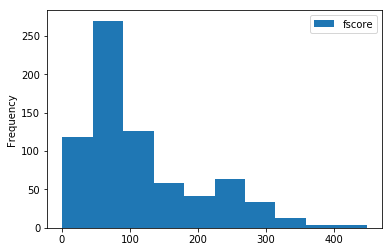

In [19]:
%matplotlib inline
sort_merged.plot(kind='hist')

In [12]:
merged = merged.drop_duplicates()
len(merged)

674

In [13]:
merged.head()

,feature,fscore
0,ps_car_14+ps_ind_03,446
1,ps_reg_03+ps_ind_03,392
2,ps_car_13+ps_reg_01,355
3,ps_car_13+ps_reg_02,347
4,ps_reg_03+ps_ind_15,338


In [14]:
len(set(merged['feature'])), len(merged)

(624, 674)

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import IsolationForest

In [14]:
train=pd.read_csv('train.csv',na_values=-1)
test=pd.read_csv('test.csv',na_values=-1)

In [15]:
# num_col = train.columns[['cat' not in item and 'bin' not in item for item in train.columns]]
# iso_train = train[num_col]
# iso_train.drop(['id', 'target'], axis=1, inplace=True)
# isf = IsolationForest(max_samples = 10*10**4, random_state=42, contamination=0.1)
# isf.fit(iso_train)
# y_pred_train = isf.predict(iso_train)
# iso_train['is_outlier'] = y_pred_train

# train = train[iso_train['is_outlier'] == 1]
# features = train.drop(['id','target'], axis=1).values
# targets = train.target.values

In [16]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

In [4]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

In [5]:
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1) 

In [17]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [18]:
X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [19]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [20]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [22]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_test, y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)

[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.05479	valid-gini:0.03578
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.326695	valid-gini:0.265545
[200]	train-error:0.036443	valid-error:0.036449	train-gini:0.377005	valid-gini:0.27505
[300]	train-error:0.036426	valid-error:0.036466	train-gini:0.423122	valid-gini:0.279963
[400]	train-error:0.03642	valid-error:0.036466	train-gini:0.459814	valid-gini:0.280923
Stopping. Best iteration:
[391]	train-error:0.03642	valid-error:0.036466	train-gini:0.456776	valid-gini:0.281033



In [17]:
param_dist = {
    'min_child_weight': [5,7,9],
    'max_depth': [5, 6, 7],
    'max_delta_step': [1, 1.5, 1.8, 2.0], 
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.6, 0.8],
    'learning_rate': [0.05, 0.1, 0.15],
    'gamma': [0.5, 0.65, 0.8],
    'n_estimators' : [500, 750, 1000, 1500],
    }

fit_dict = {"eval_set":[(X_test, y_test)],
            "early_stopping_rounds": 70,
            'eval_metric' : 'auc'}

In [18]:
# run randomized search
from sklearn.metrics import make_scorer
# def gini(actual, pred, cmpcol = 0, sortcol = 1):
#     assert( len(actual) == len(pred) )
#     tmp = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
#     tmp = tmp[ np.lexsort((all[:,2], -1*all[:,1])) ]
#     totalLosses = tmp[:,0].sum()
#     giniSum = tmp[:,0].cumsum().sum() / totalLosses
    
#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)
 
# def gini_normalized(a, p):
#     return gini(a, p) / gini(a, a)

# def gini_xgb(preds, dtrain):
#     labels = dtrain.get_label()
#     gini_score = gini_normalized(labels, preds)
#     return 'gini', gini_score

xgb_tune = xgb.XGBClassifier(random_state=42, objective='binary:logistic')
n_iter_search = 200
# gini_scorer = make_scorer(gini_normalized, greater_is_better=True)
random_search = RandomizedSearchCV(estimator = xgb_tune, 
                                   param_distributions = param_dist,
                                   scoring = 'roc_auc',
                                   n_iter=n_iter_search, 
                                   random_state=42, 
                                   cv=3, 
                                   verbose=3, 
                                   n_jobs=8,
                                   fit_params=fit_dict)
start = time()
random_search.fit(X_train, y_train)
print time()-start

C:\Users\KrystalU\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:583: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 60.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 124.6min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 217.9min
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed: 271.2min finished


[0]	validation_0-auc:0.513435
Will train until validation_0-auc hasn't improved in 70 rounds.
[1]	validation_0-auc:0.586185
[2]	validation_0-auc:0.607289
[3]	validation_0-auc:0.614942
[4]	validation_0-auc:0.617243
[5]	validation_0-auc:0.616665
[6]	validation_0-auc:0.617865
[7]	validation_0-auc:0.618238
[8]	validation_0-auc:0.6197
[9]	validation_0-auc:0.620638
[10]	validation_0-auc:0.62137
[11]	validation_0-auc:0.621087
[12]	validation_0-auc:0.621461
[13]	validation_0-auc:0.621912
[14]	validation_0-auc:0.623045
[15]	validation_0-auc:0.623468
[16]	validation_0-auc:0.624533
[17]	validation_0-auc:0.624813
[18]	validation_0-auc:0.623894
[19]	validation_0-auc:0.624155
[20]	validation_0-auc:0.624344
[21]	validation_0-auc:0.62443
[22]	validation_0-auc:0.624547
[23]	validation_0-auc:0.624573
[24]	validation_0-auc:0.624373
[25]	validation_0-auc:0.624141
[26]	validation_0-auc:0.623911
[27]	validation_0-auc:0.624255
[28]	validation_0-auc:0.624255
[29]	validation_0-auc:0.624337
[30]	validation_0-au

[259]	validation_0-auc:0.639124
[260]	validation_0-auc:0.639134
[261]	validation_0-auc:0.639066
[262]	validation_0-auc:0.63906
[263]	validation_0-auc:0.63912
[264]	validation_0-auc:0.639129
[265]	validation_0-auc:0.639086
[266]	validation_0-auc:0.639049
[267]	validation_0-auc:0.639068
[268]	validation_0-auc:0.639121
[269]	validation_0-auc:0.639152
[270]	validation_0-auc:0.639131
[271]	validation_0-auc:0.639043
[272]	validation_0-auc:0.639055
[273]	validation_0-auc:0.639069
[274]	validation_0-auc:0.639064
[275]	validation_0-auc:0.638979
[276]	validation_0-auc:0.638941
[277]	validation_0-auc:0.639081
[278]	validation_0-auc:0.639063
[279]	validation_0-auc:0.638945
[280]	validation_0-auc:0.639041
[281]	validation_0-auc:0.639025
[282]	validation_0-auc:0.639047
[283]	validation_0-auc:0.639021
[284]	validation_0-auc:0.639023
[285]	validation_0-auc:0.639039
[286]	validation_0-auc:0.638991
[287]	validation_0-auc:0.63903
[288]	validation_0-auc:0.639005
[289]	validation_0-auc:0.638998
[290]	valid

[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 60.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 124.6min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 217.9min
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed: 271.2min finished

In [2]:
16626/3600

4

In [19]:
random_search.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.8,
 'learning_rate': 0.05,
 'max_delta_step': 1.8,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 1000,
 'subsample': 0.6}

In [13]:
random_search.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_delta_step': 1,
 'max_depth': 7,
 'min_child_weight': 9,
 'n_estimators': 500,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [20]:
pred_prob = random_search.best_estimator_.predict_proba(test.values)

In [21]:
sub['target'] = pred_prob[:,1]
sub.to_csv('sub3.csv',index=False)

## LGB

In [ ]:
import lightgbm as lgb

In [ ]:
param_dist = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.001, 0.025, 0.05, 0.1],
    'num_trees' : [500, 1000, 1500, 2000],
    'num_leaves': [31, 63, 81]
    'max_bin': [255, 299, 351],
    'boosting':['gbdt', 'rf', 'dart'],
    
    }

fit_dict = {"eval_set":[(X_test, y_test)],
            "early_stopping_rounds": 70,
            'metric': 'auc'}

In [ ]:
xgb_tune = lgb.XGBClassifier(random_state=42, objective='binary')
n_iter_search = 200
# gini_scorer = make_scorer(gini_normalized, greater_is_better=True)
random_search = RandomizedSearchCV(estimator = xgb_tune, 
                                   param_distributions = param_dist,
                                   scoring = 'roc_auc',
                                   n_iter=n_iter_search, 
                                   random_state=42, 
                                   cv=3, 
                                   verbose=3, 
                                   n_jobs=8,
                                   fit_params=fit_dict)
start = time()
random_search.fit(X_train, y_train)
print time()-start